In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [3]:
# Some functions to help out with
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
data_folder_path = '../raw_data/joe'

In [5]:
import os

data_files = os.listdir(data_folder_path)

test_file = data_folder_path + '/' + data_files[0]

# os.path.join(data_folder_path, data_files[0])

test_file

'../raw_data/joe/JPM_2006-01-01_to_2018-01-01.csv'

In [6]:
test_df = pd.read_csv(test_file)

test_df.shape

(3020, 7)

In [8]:
import os
fileList = os.listdir(data_folder_path)

In [9]:
companyList = []
for file in fileList:
    companyName = file.split("_")[0]
    if companyName != "all":
        companyList.append(companyName)
print(companyList)

['JPM', 'MSFT', 'JNJ', 'SP500', 'UNH', 'CAT', 'AABA', 'HD', 'CVX', 'MMM', 'AMZN', 'CSCO', 'XOM', 'VZ', 'WMT', 'GS', 'AAPL', 'AXP', 'GOOGL', 'UTX', 'KO', 'MRK', 'TRV', 'IBM', 'INTC', 'PFE', 'GE', 'DIS', 'PG', 'BA', 'MCD', 'NKE']


In [10]:
# First, we get the data
stockList = ["GE", "MSFT", "GOOGL", "AAPL", "AMZN", "IBM", "CSCO"]
#
df_ = {}
for i in stockList:
    df_[i] = pd.read_csv(data_folder_path+ "/" + i + "_2006-01-01_to_2018-01-01.csv", index_col="Date", parse_dates=["Date"])

In [11]:
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2015", "Close")

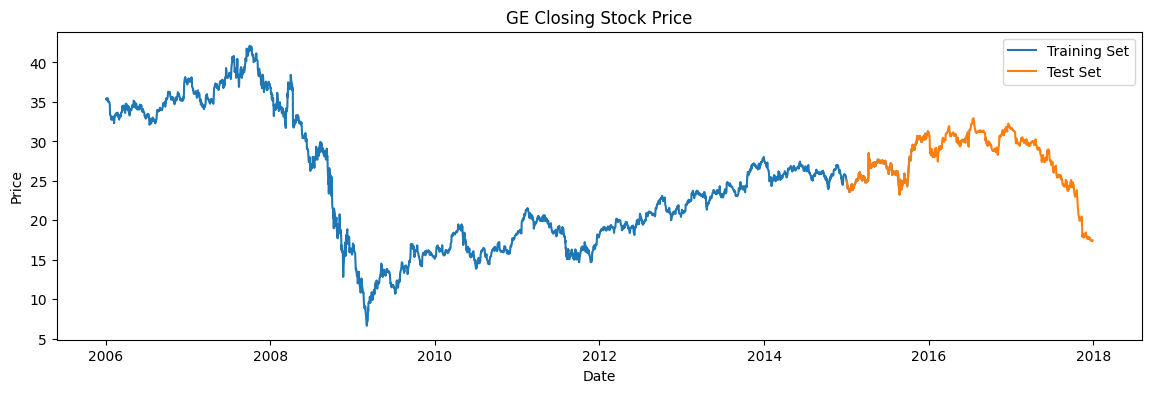

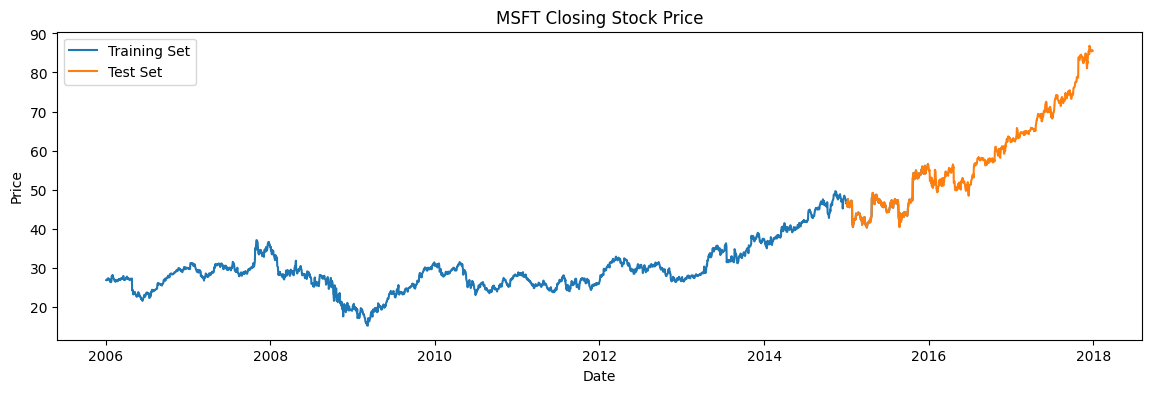

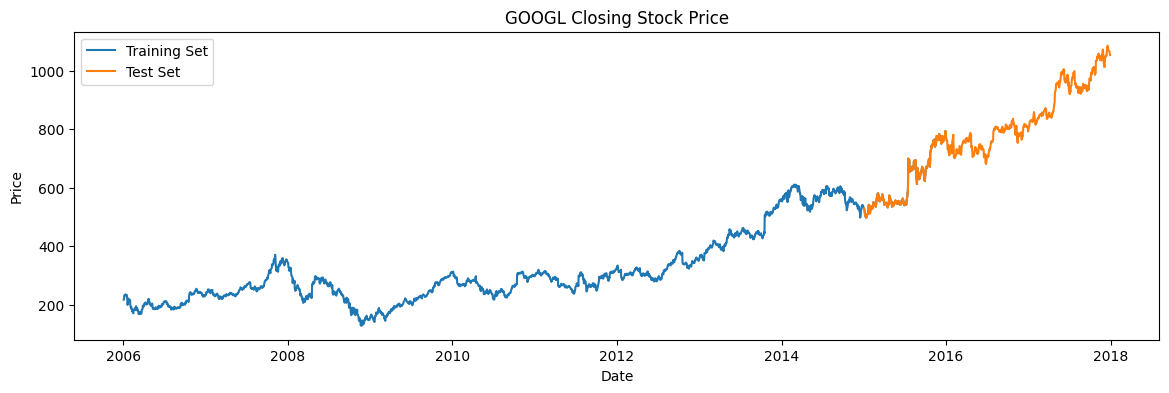

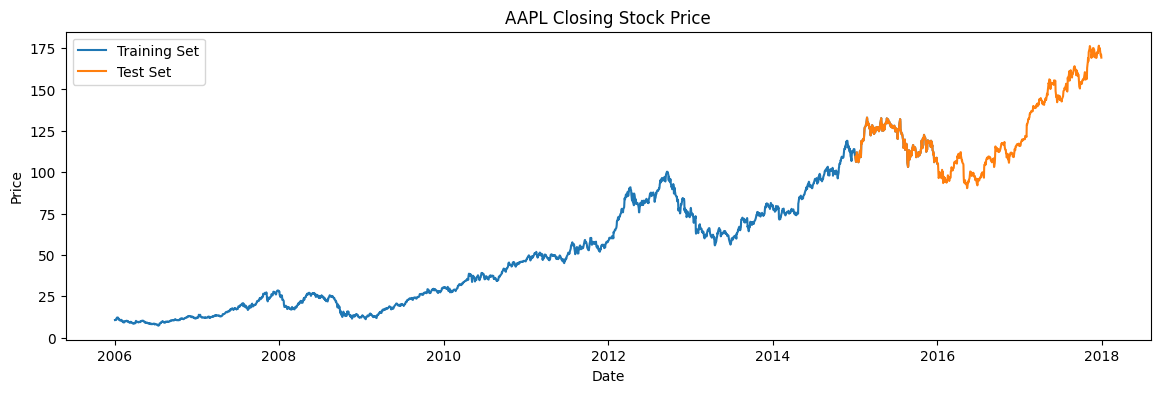

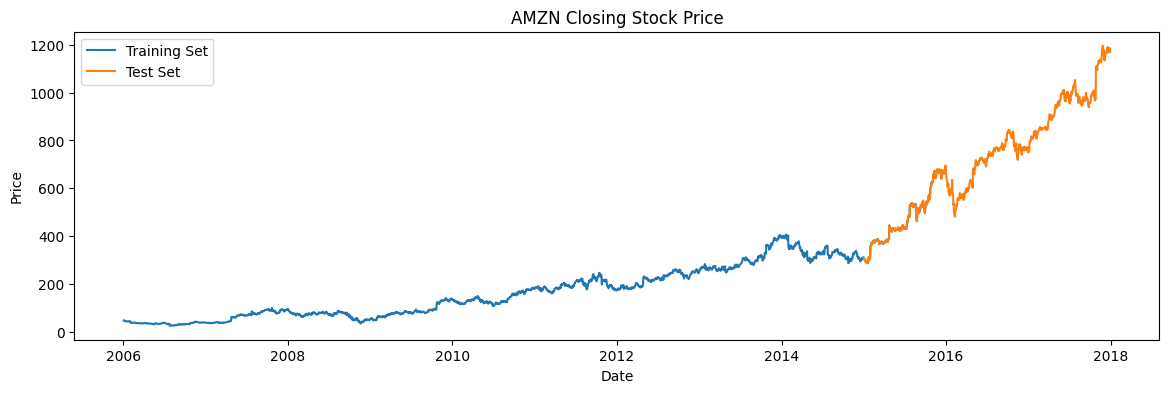

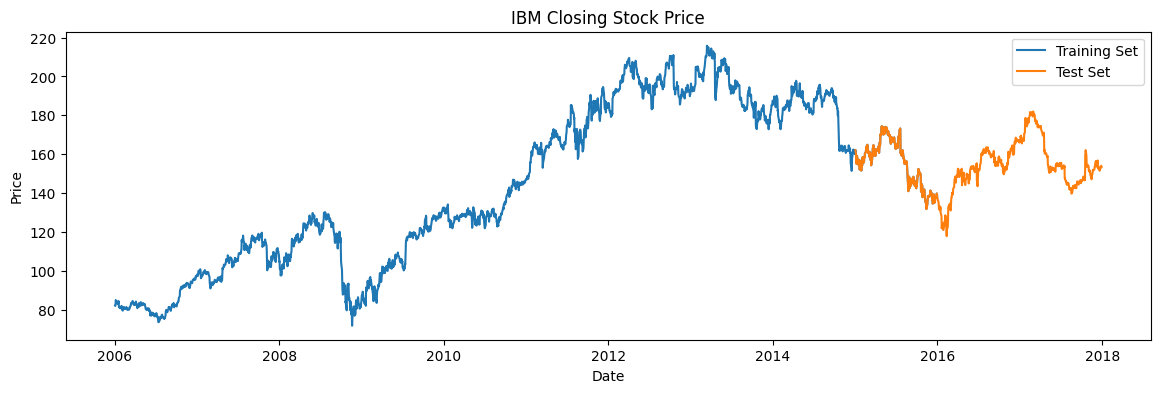

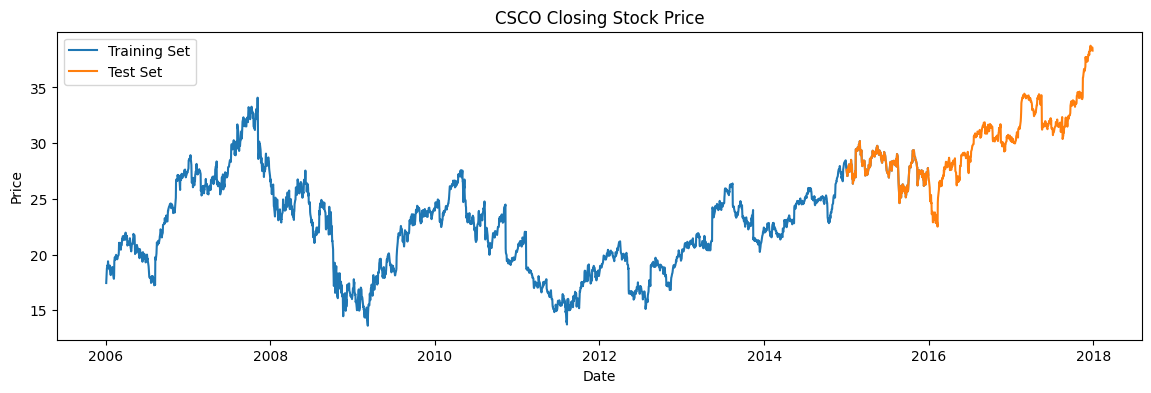

In [12]:
for i in stockList:
    plt.figure(figsize=(14,4))
    plt.plot(df_new[i]["Train"])
    plt.plot(df_new[i]["Test"])
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(["Training Set", "Test Set"])
    plt.title(i + " Closing Stock Price")

In [13]:
# Scaling the training set
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range=(0,1))
    a0 = np.array(df_new[i]["Train"])
    a1 = np.array(df_new[i]["Test"])
    a0 = a0.reshape(a0.shape[0],1)
    a1 = a1.reshape(a1.shape[0],1)
    transform_train[i] = sc.fit_transform(a0)
    transform_test[i] = sc.fit_transform(a1)
    scaler[i] = sc

del a0
del a1

In [14]:
for i in transform_train.keys():
    print(i, transform_train[i].shape)
print("\n")
for i in transform_test.keys():
    print(i, transform_test[i].shape)

GE (2517, 1)
MSFT (2516, 1)
GOOGL (2516, 1)
AAPL (2516, 1)
AMZN (2516, 1)
IBM (2517, 1)
CSCO (2516, 1)


GE (755, 1)
MSFT (755, 1)
GOOGL (755, 1)
AAPL (755, 1)
AMZN (755, 1)
IBM (755, 1)
CSCO (755, 1)


In [15]:
trainset = {}
testset = {}
for j in stockList:
    trainset[j] = {}
    X_train = []
    y_train = []
    for i in range(60,2516):
        X_train.append(transform_train[j][i-60:i,0])
        y_train.append(transform_train[j][i,0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    trainset[j]["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
    trainset[j]["y"] = y_train

    testset[j] = {}
    X_test = []
    y_test = []
    for i in range(60, 755):
        X_test.append(transform_test[j][i-60:i,0])
        y_test.append(transform_test[j][i,0])
    X_test, y_test = np.array(X_test), np.array(y_test)
    testset[j]["X"] = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))
    testset[j]["y"] = y_test


In [16]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')
# Fitting to the training set
stockList2 = ["CSCO"]
for i in stockList2:
    print("Fitting to", i)
    history=regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=20, batch_size=200)

Fitting to CSCO
Epoch 1/20


2024-06-11 09:51:24.336777: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13/13 [==============================] - 6s 177ms/step - loss: 0.0626
Epoch 2/20
13/13 [==============================] - 3s 194ms/step - loss: 0.0210
Epoch 3/20
13/13 [==============================] - 3s 205ms/step - loss: 0.0140
Epoch 4/20
13/13 [==============================] - 3s 216ms/step - loss: 0.0118
Epoch 5/20
13/13 [==============================] - 3s 215ms/step - loss: 0.0104
Epoch 6/20
13/13 [==============================] - 3s 226ms/step - loss: 0.0101
Epoch 7/20
13/13 [==============================] - 3s 218ms/step - loss: 0.0103
Epoch 8/20
13/13 [==============================] - 3s 202ms/step - loss: 0.0100
Epoch 9/20
13/13 [==============================] - 3s 207ms/step - loss: 0.0094
Epoch 10/20
13/13 [==============================] - 3s 208ms/step - loss: 0.0091
Epoch 11/20
13/13 [==============================] - 3s 208ms/step - loss: 0.0089
Epoch 12/20
13/13 [==============================] - 3s 204ms/step - loss: 0.0086
Epoch 13/20
13/13 [=================

22/22 [==============================] - 0s 12ms/step


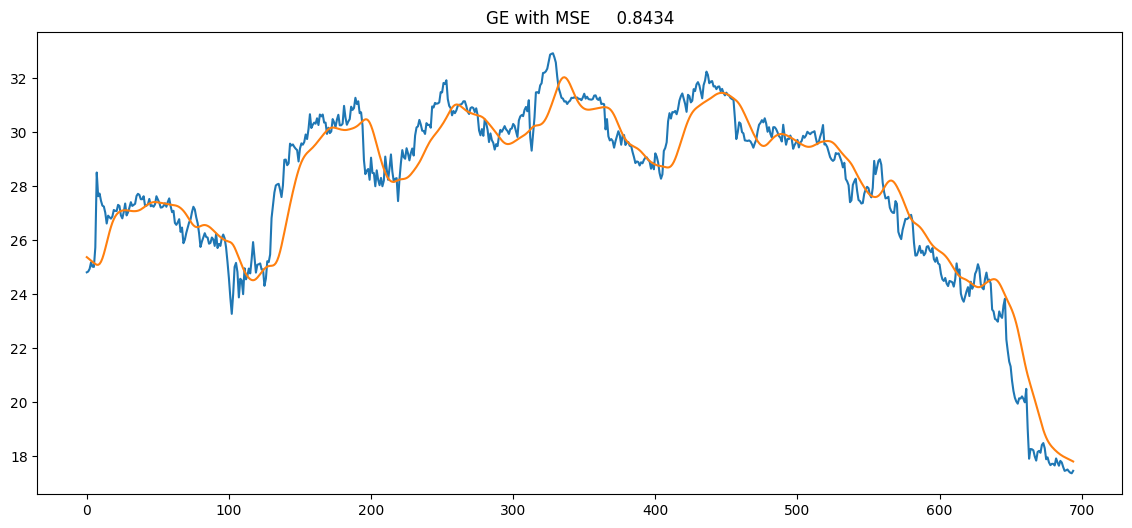

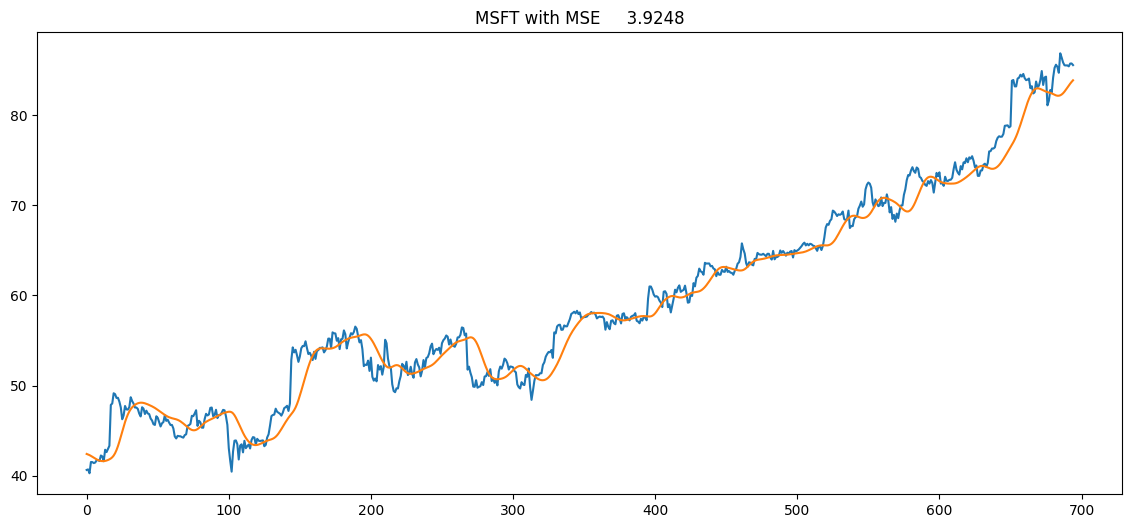

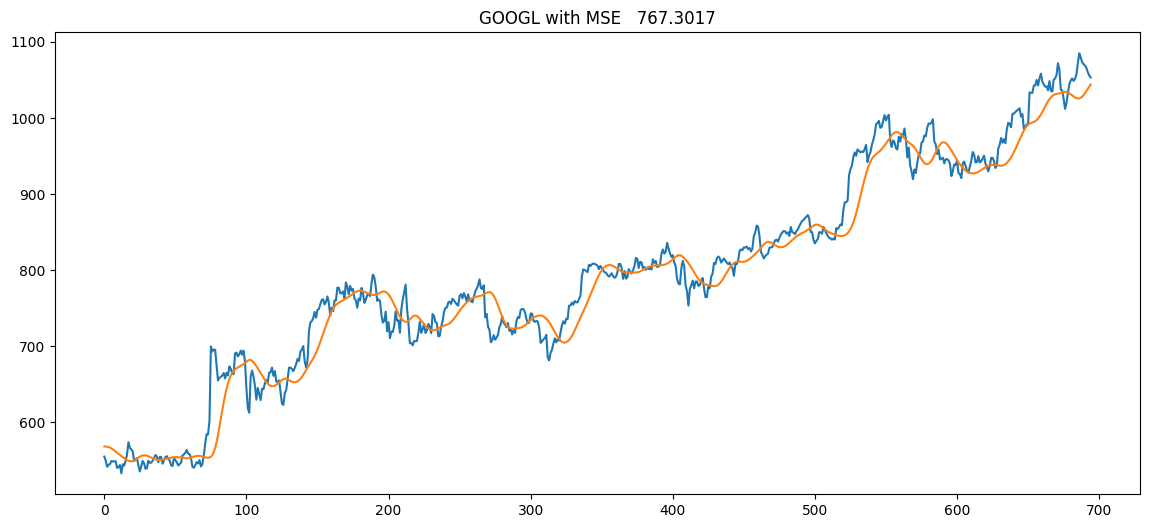

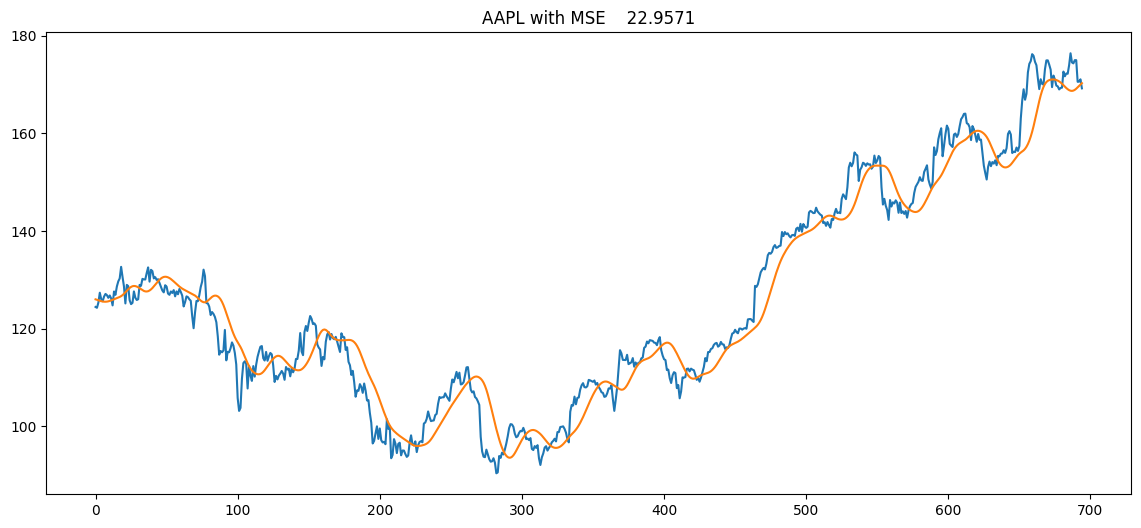

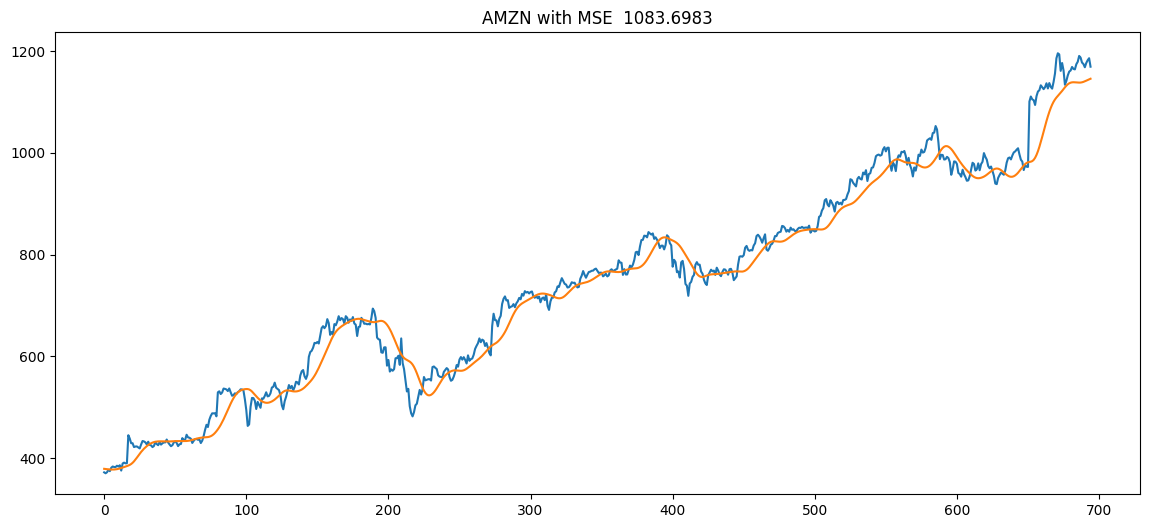

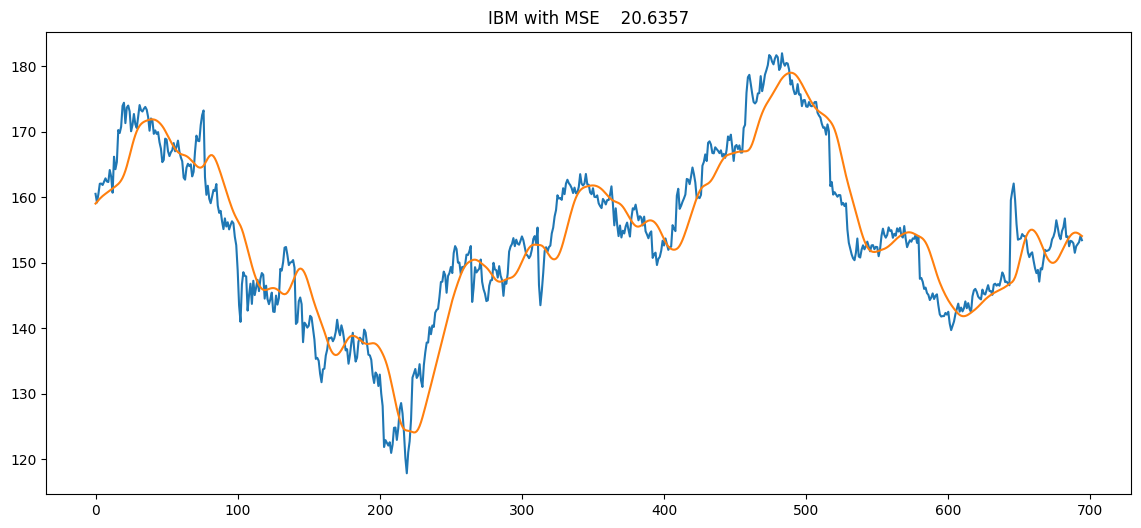

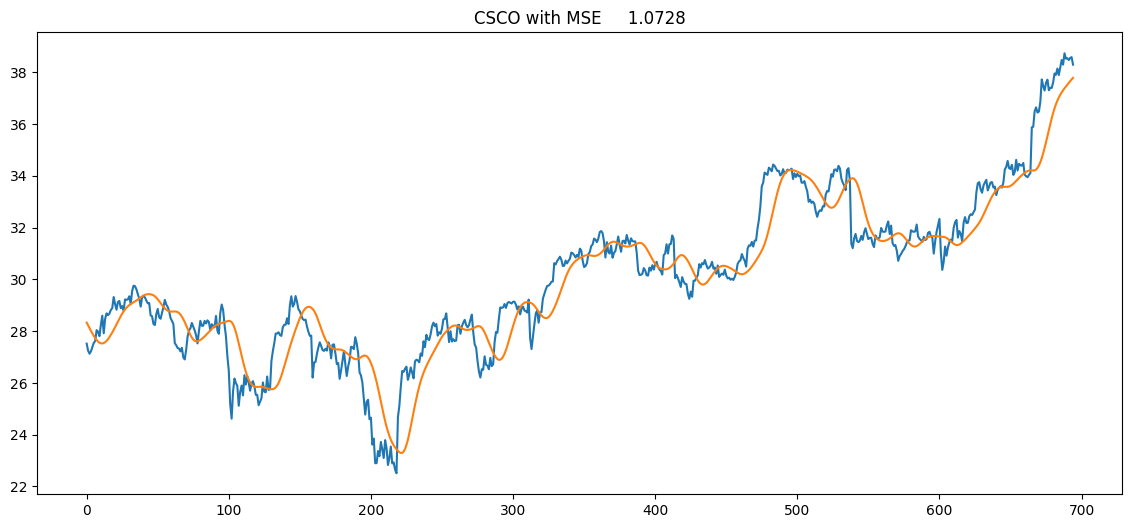

In [17]:
pred_result = {}
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MSE = mean_squared_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred

    plt.figure(figsize=(14,6))
    plt.title("{} with MSE {:10.4f}".format(i,MSE))
    plt.plot(y_true)
    plt.plot(y_pred)

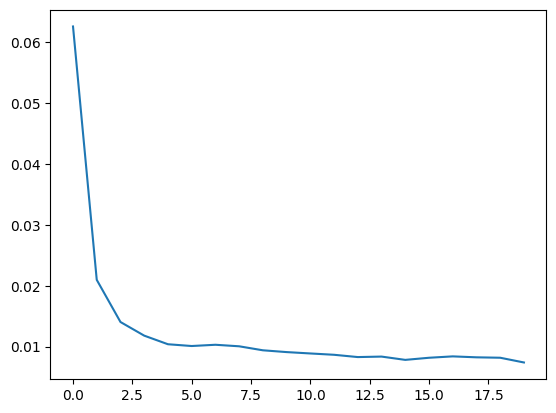

In [18]:
history.history['loss']
plt.plot(history.history['loss'])

In [19]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
history=[]
for i in stockList:
    print("Fitting to", i)
    history.append(regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=30, batch_size=200))


Fitting to GE
Epoch 1/30
13/13 [==============================] - 6s 198ms/step - loss: 0.2568
Epoch 2/30
13/13 [==============================] - 3s 195ms/step - loss: 0.1255
Epoch 3/30
13/13 [==============================] - 3s 203ms/step - loss: 0.0882
Epoch 4/30
13/13 [==============================] - 3s 208ms/step - loss: 0.0787
Epoch 5/30
13/13 [==============================] - 3s 205ms/step - loss: 0.0766
Epoch 6/30
13/13 [==============================] - 3s 217ms/step - loss: 0.0753
Epoch 7/30
13/13 [==============================] - 3s 198ms/step - loss: 0.0719
Epoch 8/30
13/13 [==============================] - 3s 195ms/step - loss: 0.0698
Epoch 9/30
13/13 [==============================] - 3s 209ms/step - loss: 0.0693
Epoch 10/30
13/13 [==============================] - 3s 223ms/step - loss: 0.0659
Epoch 11/30
13/13 [==============================] - 3s 201ms/step - loss: 0.0699
Epoch 12/30
13/13 [==============================] - 3s 204ms/step - loss: 0.0660
Epoch 13/30

22/22 [==============================] - 0s 12ms/step


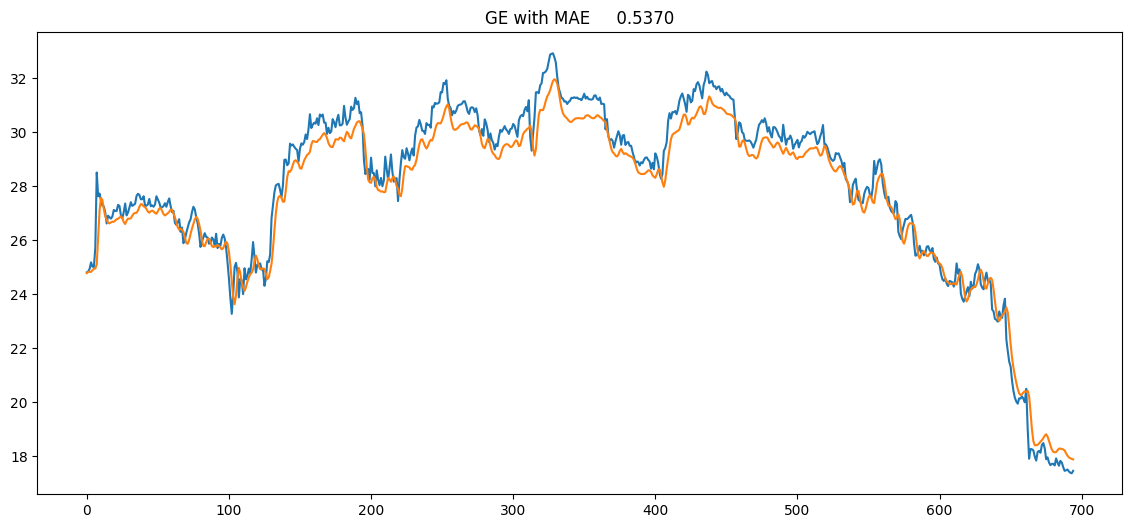

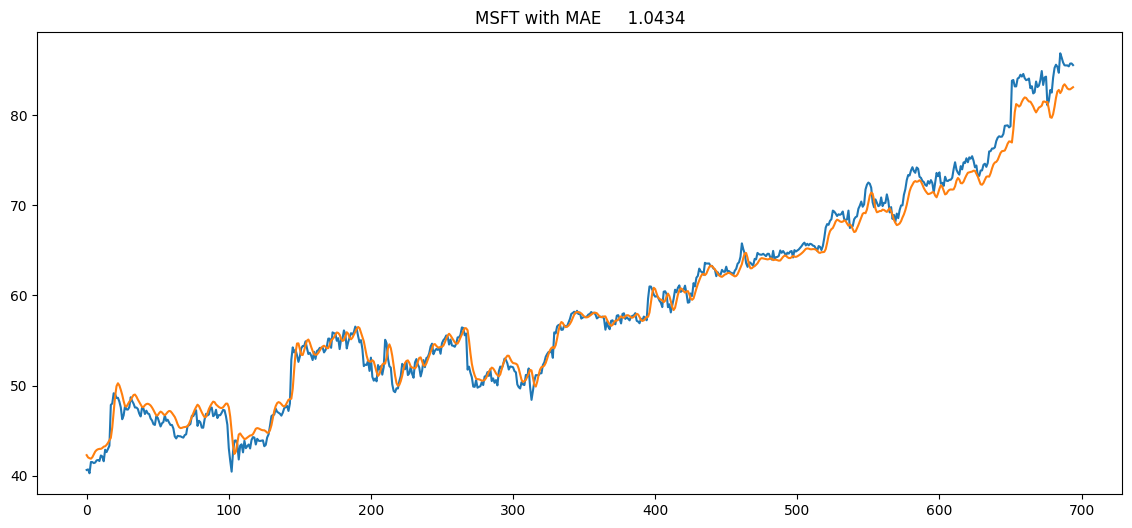

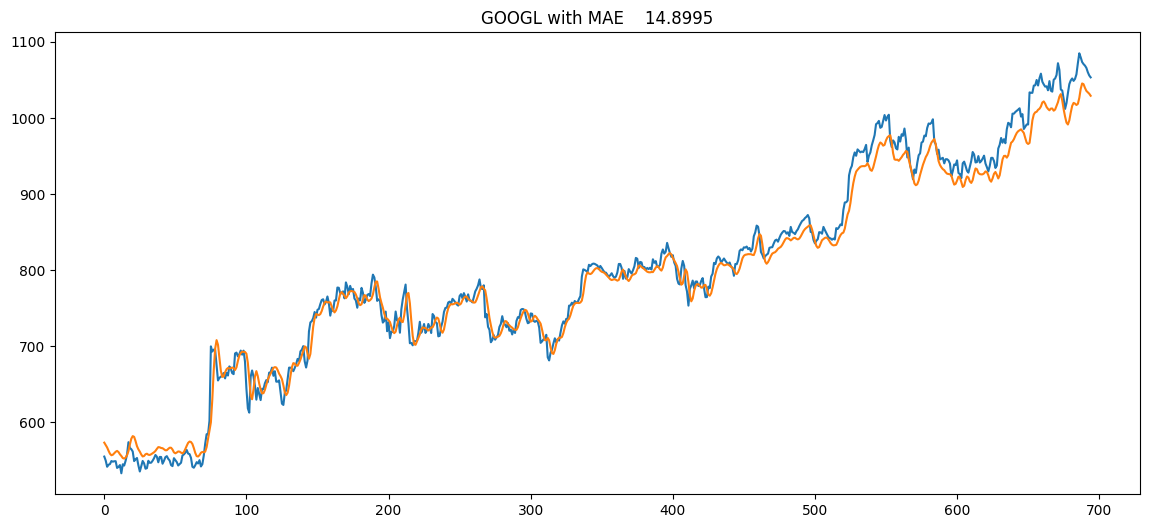

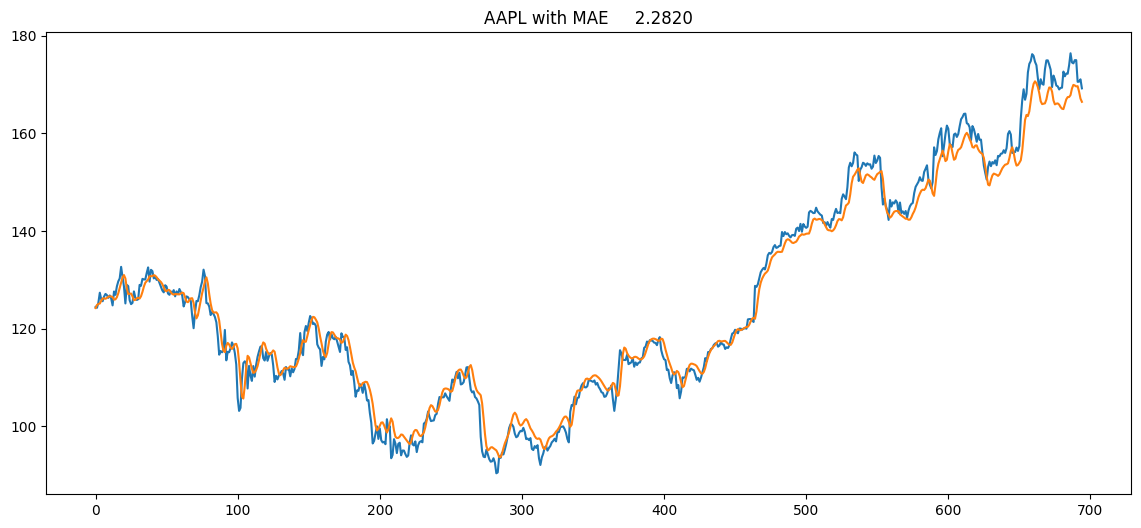

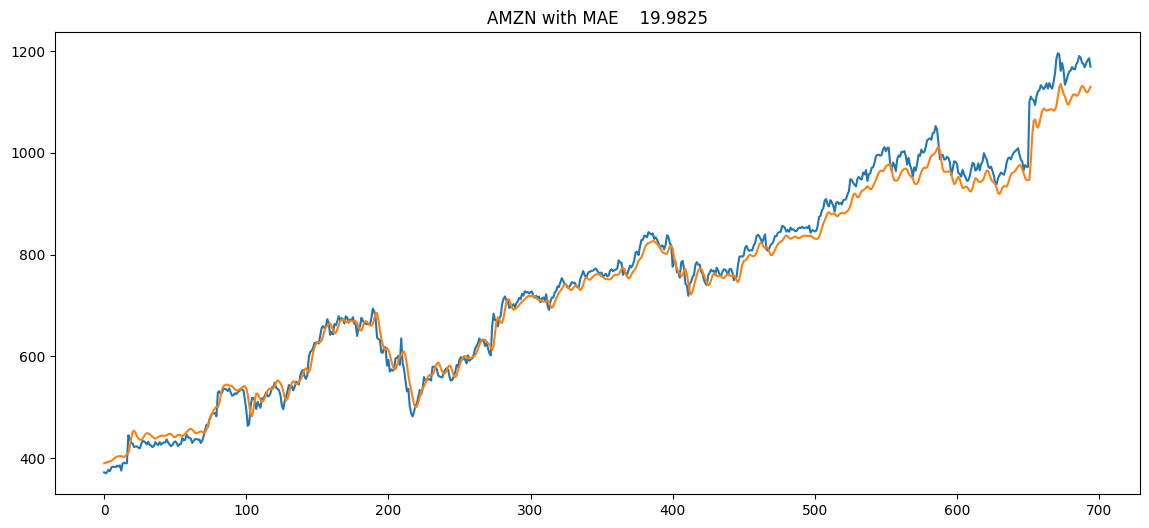

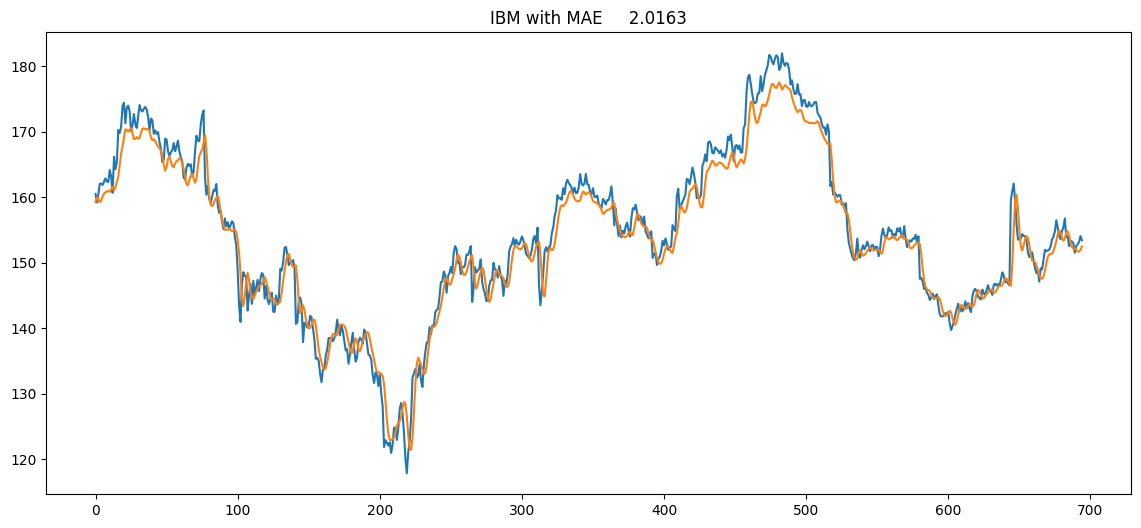

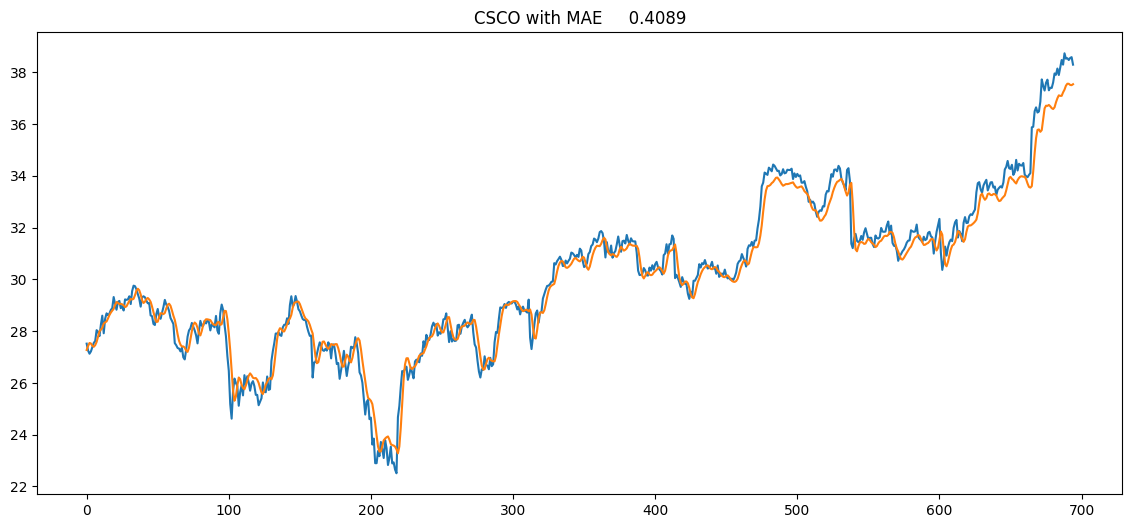

In [20]:
from sklearn.metrics import mean_absolute_error
pred_result = {}
for i in stockList:
    y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
    y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
    MAE = mean_absolute_error(y_true, y_pred)
    pred_result[i] = {}
    pred_result[i]["True"] = y_true
    pred_result[i]["Pred"] = y_pred

    plt.figure(figsize=(14,6))
    plt.title("{} with MAE {:10.4f}".format(i,MAE))
    plt.plot(y_true)
    plt.plot(y_pred)

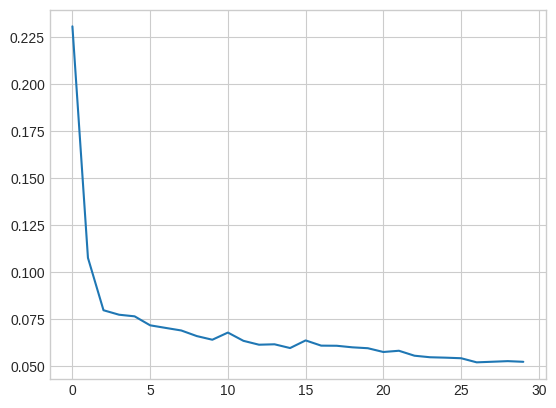

In [30]:
plt.plot(history[0].history['loss'])